## Uncertainty Quantifications - Monte Carlo Simulations

---

This notebook will quantify log k values for various species using a Monte Carlo method with lower and upper bounds from literature. See below:

Mahoney et al. (2009). Uranyl Adsorption on to Hydrous Ferric Oxcide--A Re-Evaluation for the Diffuse Layer Model Database. *Environmental Science and Technology,* *43*(24), 9263. doi: 10.1021/es901586w

#### Set up initial parameters and uncertainty bounds

*pqcpath*: path to phreeqc.bat executable

*TDBfile*: name of phreeqc database file without file extension

*outfile*: name of phreeqc output file including file extension

*infile*: name of phreeqc input file including file extension

*num_iterations*: controls how many phreeqc runs are done

In [1]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

# these are used when we run phreeqc in MC_sim()
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'
TDBfile = 'llnl_Mahoney_updated'
outfile = 'Outputfile3.out'
infile = 'U_HFO_input3.txt'
num_iterations = 9 #probably ~100 is good for 4 parameters

# bounds from table 2 in Mahoney et. al.
pars    = ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
lower = [1.62, 1.79, 8.75, 15.1]
upper = [5.85, 3.28, 9.32, 15.28]


# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            print("verify: bounds check out")
            return True
        print("verify: error -- listed bounds are inconsistent")
        return False
    
    print("verify: error -- lists are different lenghts")
    return False



# searches for the '-find ' key in the input file to get the name of the .sel output file
def find_opsel(infile):
    
    with open(infile, 'r') as f:
        for line in f.readlines():
            if line.find("-file ") > 0:
                return line[line.find("-file ")+len("-file "):-1]
            
    print("error: unable to find output file in {}".format(infile))
    return -1

# verify bounds and set phreeqc output to read
verify(lower, upper)
opsel = find_opsel(infile)
#opsel

verify: bounds check out


#### Generate values from probablilty distributions

In a Monte Carlo simulation we will generate random values for the parameters within the upper/lower bounds for each run

In [2]:
# import shutil

# returns a matrix of random values between lower and upper
def get_random_values(lower, upper, num_iterations):
    # lower, upper: lists of bounds to generate within
    # num_iterations: number of rows to generate
    # return: num_iterations by len(lower) matrix
    
    # generate 1 row
    matrix = np.zeros(len(lower))
    for i in range(len(lower)):
        matrix[i] = numpy.random.uniform(lower[i], upper[i])
        
    # generate more rows if needed
    if num_iterations < 2:
        return [matrix]
    else:
        for j in range(num_iterations-1):
            values = np.zeros(len(lower))
            for i in range(len(lower)):
                values[i] = numpy.random.uniform(lower[i], upper[i])
            matrix = np.vstack((matrix, values))
        return matrix

# runs x phreeqc simulations where x is the height of values_mtrx
# requires various path variables to be set correctly at beginning of file
def MC_sim(values_mtrx, analytes=['pH', 'U']):
    # values_mtrx: matrix of values generated from get_random_values or similar function
    # analytes: list of element keywords to search for in .out file generated by phreeqc
    # return: list of np arrays of [sim#, analyte1, analyte2...]
    
    obs_all = []
    for values in values_mtrx:        
        # deletes output.sel and output.txt before each iteration (assume they are in same dir)
        # enabling these steps can help verify phreeqc is correctly generating new output files
#         if os.path.exists("Outputfile.out"):
#             os.remove("Outputfile.out")
#         if os.path.exists("U_HFO_Complexation_Output_Trial3.sel"):
#             os.remove("U_HFO_Complexation_Output_Trial3.sel")

        writeInput(TDBfile, pars, values)
        
        # the .read() here is essential because it tells python to wait for phreeqc to
        # finish running before executing following code.
        os.popen(pqcpath+' '+infile+' '+outfile+' '+TDBfile+'.txt').read()
        
        # reads phreeqc results and appends to running list
        obs = readOutput(opsel, analytes)
        obs_all.append(obs)

        # enabling these lines can help check if the output files are updating correctly
#         shutil.copyfile('U_HFO_Complexation_Output_Trial3.sel', 'U_HFO_Complexation_Output_Trial3_{}.sel'.format(itr))
#         shutil.copyfile('llnl_Mahoney_updated.txt', 'llnl_Mahoney_updated{}.txt'.format(itr))

    return obs_all

gen_values = get_random_values(lower, upper, num_iterations)
res = MC_sim(gen_values)
#res

In [12]:
res

[array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [8.2753e-08, 3.1066e-08, 5.9327e-09, 8.5468e-10, 2.0082e-10,
         1.1123e-10]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.9017e-08, 9.1076e-08, 5.8941e-08, 1.6415e-08, 4.3832e-09,
         2.4708e-09]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.6367e-08, 7.1613e-08, 2.6085e-08, 4.6017e-09, 1.1134e-09,
         6.1905e-10]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400

#### Plotting + Residual Sum of Squares Analysis with Experimental Results

For each run from MC_sim that we did we plot pH vs Uranium concentrations in micromoles, and compare to experimental results to find the run with the least RSS value

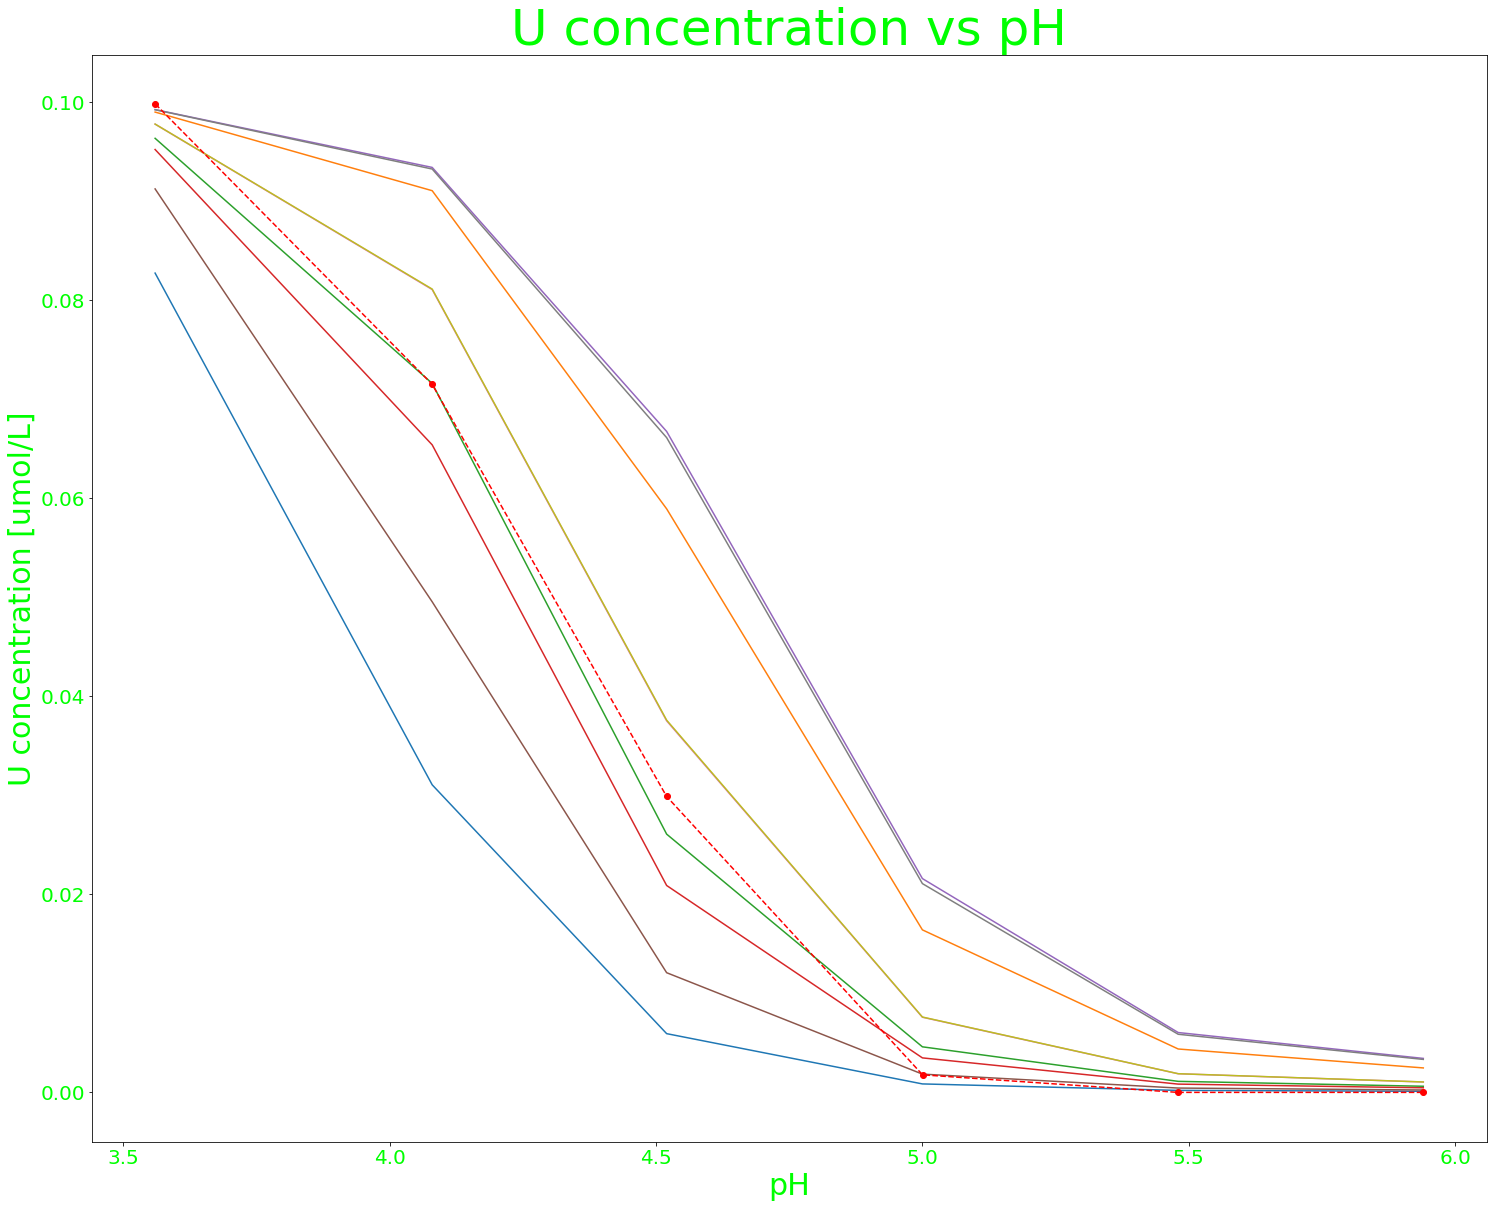

In [3]:
f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("U concentration vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('U concentration [umol/L]', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

# setting up values from experimental results
exp_pH = [3.56041,4.07969,4.51985,5.00029,5.47929,5.93959]
exp_U = [0.099831,0.071537,0.029899,0.001774,0,0]

# plotting each data from MC_sim
for run in res:
    # hard coding in plots for pH and U
    plt.plot(run[1], run[2]*1e6)

# plotting experimental results
plt.plot(exp_pH, exp_U, 'r--o')

plt.show()

For RSS analysis I think the best thing to do in this situation is to just hard-code something instead of making more comprehensive functions, since the experimental data in this case seems tailor-fit for this specific scenario. I will iterate through the list of results and find a quick residual sum of squares for each pH (approximating the pHes because they're already really close)

In [4]:
rss_list = []

for run in res:
    # rss is Sum((expected - observed)^2)
    rss = np.sum(np.square(exp_U - run[2]*1e6))
    rss_list.append(rss)

bestrun = rss_list.index(min(rss_list))
bestfit = res[rss_list.index(min(rss_list))][2]
bestanalytes = gen_values[bestrun]

print(rss_list)
print(min(rss_list), bestrun)
print("The best fitting analytes are: {} from run {}.".format(bestanalytes, bestrun))

# write a new .tpl file with the best fit analyte values
writeInput(TDBfile, pars, bestanalytes, TDBfile+"_MCnew")

[0.0025048413107377, 0.0014655490568800003, 3.617043775249995e-05, 0.0001436007542918002, 0.0022793039236499997, 0.0008743572291493004, 0.00019202537512999997, 0.00220392047252, 0.00019431272056000005]
3.617043775249995e-05 2
The best fitting analytes are: [ 4.01489232  2.7869682   9.18730326 15.21124333] from run 2.


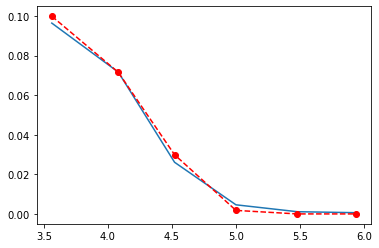

In [5]:
plt.plot(res[0][1], bestfit*1e6, exp_pH, exp_U, 'r--o')
plt.show()

#### Sensitivity Analysis

We will use the morris analysis method in the python Sensitivity Analysis Library to find which parameters are the most significant

In [43]:
from SALib.sample import morris as ssm
from SALib.analyze import morris as sam
from SALib.test_functions import Ishigami

# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!'],
    'bounds': [[1.62, 5.85],
               [1.79, 3.28],
               [8.75, 9.32],
               [15.2, 15.28]]
}


# runs MC_sim and formats results into matrix for use with morris functions
def morris_MC_sim(params, num_iterations, analyte=['U']):
    # analyte: a single analyte to measure
    # return: #simulations by #observations matrix

    sims = MC_sim(params, analyte)
    
    # [0][1] index of MC_sim will be the list of analyte values 
    morris_output = sims[0][1]
    for sim in sims[1:]:
        morris_output = np.vstack((morris_output, sim[1]))
    
    return morris_output



# Generate samples according to the morris method
# in this case it's 20*(num_vars+1) sets of 4 parameters within the bounds
X = ssm.morris.sample(problem, 20)


# Calculate model outputs
Y = morris_MC_sim(X, num_iterations)

In [50]:
# Perform Morris analysis
morris_result = [sam.analyze(problem, X, Y.T[0], conf_level=0.95, num_levels=4,
                     print_to_console=False)]

# Storing the sensitivity indices as a list of dictionaries
# each dictionary represents the results for one observation
for i_obs in range(1, np.shape(Y)[1]):
    Si = sam.analyze(problem, X, Y.T[i_obs], conf_level=0.95, num_levels=4, 
                     print_to_console=False)
    morris_result.append(Si)

In [63]:
# Making a matrix of observations by parameters
mu_all = morris_result[0].get("mu")
for obs in morris_result[1:]:
    mu_all = np.vstack((mu_all, obs.get("mu")))
mu_all

array([[-3.78315000e-08, -5.14635000e-09,  0.00000000e+00,
         0.00000000e+00],
       [-6.87666000e-08, -2.39824500e-08,  0.00000000e+00,
         0.00000000e+00],
       [-5.07837600e-08, -3.22244400e-08,  0.00000000e+00,
         0.00000000e+00],
       [-1.84966605e-08, -1.42045140e-08, -7.50000000e-14,
         0.00000000e+00],
       [-5.66039880e-09, -4.46785297e-09, -4.36500000e-13,
         0.00000000e+00],
       [-3.27448957e-09, -2.59317427e-09, -1.93807500e-12,
         0.00000000e+00]])

large mean (mu) = large response to perturbation

large sigma = elementary effects depend highly on choice of sample point (response is non-linear)

small sigma = EEs similar for different selected sample points; effect of parameter independent of other parameter values



In [ ]:
# f = plt.figure(figsize=[25,20])

# # setting plot colors so I can read the plot in a dark background notebook
# plt.xlabel('mu', fontdict={'fontsize': 30, 'color': 'lime'})
# plt.xticks(fontsize = 20, color = 'lime')
# plt.ylabel('sigma', fontdict={'fontsize': 30, 'color': 'lime'})
# plt.yticks(fontsize = 20, color = 'lime')
# plt.plot(Si['mu'], Si['sigma'], 'bo')

# for i in range(len(Si['names'])):
#     plt.annotate(Si['names'][i], (Si['mu'][i], Si['sigma'][i]), fontsize=20, color='lime')

from a youtube video https://www.youtube.com/watch?v=P8Rfipkid3w:

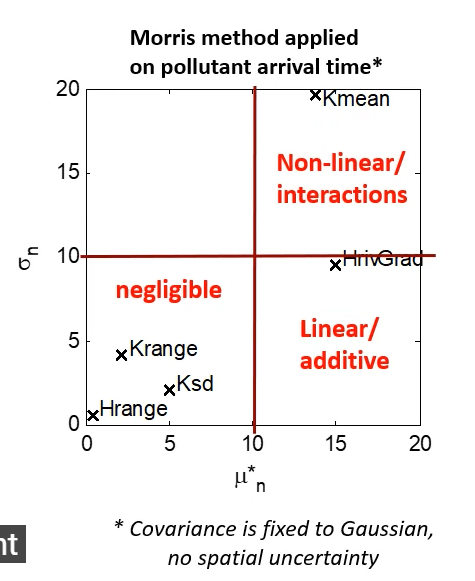

